## Title: Global Ecological Zones (second edition) FAO 2010
### Description
The Global Forest Resources Assessment (FRA) of the Food and Agriculture Organization of the United Nations (FAO) presents global and regional forest data by global ecological zone (GEZ). The GEZ spatial dataset used by FAO has developed over the years from covering only the tropical areas (1990) to the globe (2000). Due to the developments in remote sensing and the compiling of many spatial products relating to climate and land cover between 2000 and 2010, an update to the map was commissioned and resulted in the available GEZ 2010 product.

Main uses of the map include: a) reporting purposes, to provide baseline forest statistics by ecological zone; b) analysis and modelling purposes, i.e. assessment of forest-based biological diversity, both at ecosystem and species level, and biomass modelling.

### FLINT
This dataset has been pre-processed/checked and is suitable for use in FLINT. Please adhere to individual dataset licence conditions and citations. Processed data can be accessed here: https://datasets.mojaglobal.workers.dev/

### Original source
Direct Download: http://www.fao.org/geonetwork/srv/en/resources.get?id=47105&fname=gez2010.zip&access=private
Access: http://www.fao.org/geonetwork/srv/en/main.home?uuid=2fb209d0-fd34-4e5e-a3d8-a13c241eb61b#
Report: http://www.fao.org/3/ap861e/ap861e00.pdf

### Licence
Copyright: Exclusive right to the publication, production, or sale of the rights to a literary, dramatic, musical, or artistic work, or to the use of a commercial print or label, granted by law for a specified period of time to an author, composer, artist, distributor

Use: Non-Commercial use

Licence: All rights reserved. FAO encourages the reproduction and dissemination of material in this information product. Non-commercial uses will be authorized free of charge, upon request. Reproduction for resale or other commercial purposes, including educational purposes, may incur fees. Applications for permission to reproduce or disseminate FAO copyright materials, and allqueries concerning rights and licences, should be addressed by e-mail to copyright@fao.org or to the Chief, Publishing Policy and Support Branch, Office of Knowledge Exchange, Research and Extension, FAO, Viale delle Terme di Caracalla, 00153 Rome, Italy.

### Citation
FOOD AND AGRICULTURE ORGANIZATION OF THE UNITED NATIONS (2012). Global ecological zones for fao forest reporting: 2010 Update. Forest Resources Assessment Working Paper 179 http://www.fao.org/3/ap861e/ap861e00.pdf

### Format
Global coverage, vector, .geojson
Cordinate system EPSG: 4326 (WGS84)
Size: 237 MB

### Metadata
http://www.fao.org/geonetwork/srv/en/main.home?uuid=2fb209d0-fd34-4e5e-a3d8-a13c241eb61b#
tags: climate , FRA , forests , ecological zone , land cover

### Notes
GEZ mapping is coarse grained in some instances, with coastline and islands often cut from mapping.

### Processing
Repair geometry, fix topologial error (remove overlaps), convert to geojson, EPSG:4326 (WGS84), remove/disable Z values. View code below - originally processed in ArcGIS but can be converted to open source QGIS or GDAL (or others).

#### Using Arcpy

In [ ]:
# Import arcpy module
import arcpy

# Local variables:
in_shp = r"C:/Users/LennyJenny/Documents/ArcGIS/world/UNFCCC/downloads/test/gez_2010_wgs84.shp"
Output_Coordinate_System = "GCS_WGS_1984"
output = "C:/data/gez_2010.geojson"

# output topological fix shapefile if topological error (optional)
in_shp_fix = r"C:/data/gez_2010_wgs84_fix.shp"

# Set output environments
arcpy.env.outputCoordinateSystem = Output_Coordinate_System
arcpy.env.outputZFlag = "Disabled"

# Process: Repair Geometry to remove self intersections and non-simple geometry
arcpy.RepairGeometry_management(in_shp, "DELETE_NULL")

# Process: Count Overlapping Features to determine topological error
# Where count<2 = topological error which will require manual fix or batch clip overlapping areas
countname = r"C:/data/overlap_count.shp"
arcpy.analysis.CountOverlappingFeatures(in_shp, countname, min_overlap_count=2)

# Process: Topoloogical fix: Find overlaps and clip from layer (non-manual, will produce gaps, this can be coded to not leave gaps later)
arcpy.analysis.Intersect(in_shp, "in_memory/intersectbits")
arcpy.analysis.Clip(in_shp, "in_memory/intersectbits", in_shp_fix)

# Process: Features To JSON
arcpy.FeaturesToJSON_conversion(input, output, "NOT_FORMATTED", "NO_Z_VALUES", "NO_M_VALUES", "GEOJSON")

#### Using Geopandas

In [1]:
import geopandas as gpd
from shapely.validation import make_valid
from itertools import combinations
import json

# Read dataset as GeoDataframe
shp = gpd.read_file('gez2010\gez_2010_wgs84.shp')

# Make geometries of dataset valid
geometries = shp.geometry
shp.geometry = geometries.apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)

# Remove overlapping polygons
geometries = shp.geometry
for c1_idx, c2_idx in combinations(geometries.index, 2):
    if geometries.loc[c1_idx].intersects(geometries.loc[c2_idx]):
        geometries.loc[c2_idx] -= geometries.loc[c1_idx]

shp.geometry = geometries

# Save as geojson
outdict = shp.__geo_interface__
outdict['name'] = "Global_Ecological_Zone_2010_wgs84"
with open('gez_2010.json','w') as f:
    json.dump(outdict,f,indent=4)

#### Plot geojson

<AxesSubplot:>

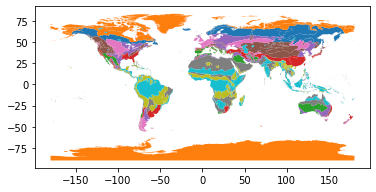

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
shp.plot(column='gez_name', ax=ax)